In [1]:
#Import
# working dir
%cd /homedtic/gmarti/CODE/RNN-VAE/
# Imports
import sys
sys.path.insert(0, '/homedtic/gmarti/CODE/RNN-VAE/')
from rnnvae.utils import open_MRI_data_var, load_multimodal_data
from rnnvae import rnnvae_h
from rnnvae.plot import plot_losses, plot_trajectory, plot_total_loss, plot_z_2d, plot_z_time_2d, plot_latent_space
import os
import math
from rnnvae.data_gen import SinDataGenerator
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import torch

%matplotlib inline

/homedtic/gmarti/CODE/RNN-VAE


In [4]:
out_dir = "/homedtic/gmarti/EXPERIMENTS/RNN-VAE/experiments_postthesis/constrained_trained_long/"
test_csv = "/homedtic/gmarti/CODE/RNN-VAE/data/multimodal_no_petfluid_test.csv"
data_cols = ['_mri_vol','_mri_cort', '_cog', '_demog', '_apoe']
# data_cols = ['_mri_vol']
#load parameters
#load parameters
p = eval(open(out_dir + "params.txt").read())
print(p)
# DEVICE
## Decidint on device on device.
DEVICE_ID = 0
DEVICE = torch.device('cuda:' + str(DEVICE_ID) if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_ID)

# Load test set
X_test, _, Y_test, _, col_lists = load_multimodal_data(test_csv, data_cols, p["ch_type"], train_set=1.0, normalize=True, return_covariates=True)

p["n_feats"] = [x[0].shape[1] for x in X_test]

mask_test_norepeat = []

# Process mask without repeated values
for x_ch in X_test:
    X_test_tensor = [ torch.FloatTensor(t) for t in x_ch]
    X_test_pad = torch.nn.utils.rnn.pad_sequence(X_test_tensor, batch_first=False, padding_value=np.nan)
    mask_test = ~torch.isnan(X_test_pad)
    mask_test_norepeat.append(mask_test.to(DEVICE))

X_test_list = []
mask_test_list = []

ntp = max(np.max([[len(xi) for xi in x] for x in X_test]), np.max([[len(xi) for xi in x] for x in X_test]))

# HERE, change bl to long and repeat the values at t0 for ntp
for i in range(len(p["ch_type"])):
    if p["ch_type"][i] == 'bl':
        #for j in range(len(X_train[i])):
        #    X_train[i][j] = np.array([X_train[i][j][0]]*ntp) 

        for j in range(len(X_test[i])):
            X_test[i][j] = np.array([X_test[i][j][0]]*ntp) 

        p["ch_type"][i] = 'long'

# Process test set
for x_ch in X_test:
    X_test_tensor = [ torch.FloatTensor(t) for t in x_ch]
    X_test_pad = torch.nn.utils.rnn.pad_sequence(X_test_tensor, batch_first=False, padding_value=np.nan)
    mask_test = ~torch.isnan(X_test_pad)
    mask_test_list.append(mask_test.to(DEVICE))
    X_test_pad[torch.isnan(X_test_pad)] = 0
    X_test_list.append(X_test_pad.to(DEVICE))

ntp = max([x.shape[0] for x in X_test_list])
"""
model = rnnvae_h.MCRNNVAE(p["h_size"], p["hidden"], p["n_layers"], 
                        p["hidden"], p["n_layers"], p["hidden"],
                        p["n_layers"], p["z_dim"], p["hidden"], p["n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], 
                        p["n_channels"], p["ch_type"], p["n_feats"], DEVICE, print_every=100, 
                        phi_layers=p["phi_layers"], sigmoid_mean=p["sig_mean"],
                        dropout=p["dropout"], dropout_threshold=p["drop_th"])
"""
model = rnnvae_h.MCRNNVAE(p["h_size"], p["x_hidden"], p["x_n_layers"], 
                        p["z_hidden"], p["z_n_layers"], p["enc_hidden"],
                        p["enc_n_layers"], p["z_dim"], p["dec_hidden"], p["dec_n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], 
                        p["n_channels"], p["ch_type"], p["n_feats"], p["c_z"], DEVICE, print_every=100, 
                        phi_layers=p["phi_layers"], sigmoid_mean=p["sig_mean"],
                        dropout=p["dropout"], dropout_threshold=p["drop_th"])
model = model.to(DEVICE)
model.load(out_dir+'model.pt')
print(model.dropout_comp)
model.dropout_threshold = 0.2
##TEST
X_test_fwd = model.predict(X_test_list, mask_test_list,nt=ntp)

{'h_size': 300, 'z_dim': 30, 'x_hidden': 300, 'x_n_layers': 1, 'z_hidden': 20, 'z_n_layers': 1, 'enc_hidden': 120, 'enc_n_layers': 0, 'dec_hidden': 120, 'dec_n_layers': 0, 'n_epochs': 2000, 'clip': 10, 'learning_rate': 0.001, 'batch_size': 128, 'seed': 1714, 'n_channels': 5, 'ch_names': ['MRI vol', 'MRI cort', 'Cog', 'Demog', 'APOE'], 'ch_type': ['long', 'long', 'long', 'bl', 'bl'], 'c_z': [30, 30, 5, 5, 5], 'phi_layers': True, 'sig_mean': False, 'dropout': True, 'drop_th': 0.4}
tensor([[0.1302, 0.1040, 0.1172, 0.1037, 0.1237, 0.1838, 0.1676, 0.1318, 0.1300,
         0.1428, 0.2084, 0.2335, 0.1549, 0.2847, 0.1543, 0.1572, 0.1084, 0.1798,
         0.2143, 0.1080, 0.1159, 0.1740, 0.1642, 0.1970, 0.3167, 0.2685, 0.1419,
         0.1117, 0.2238, 0.1919]], device='cuda:0')


(5, 180, 13, 30)
180
180


TypeError: 'ListedColormap' object is not iterable

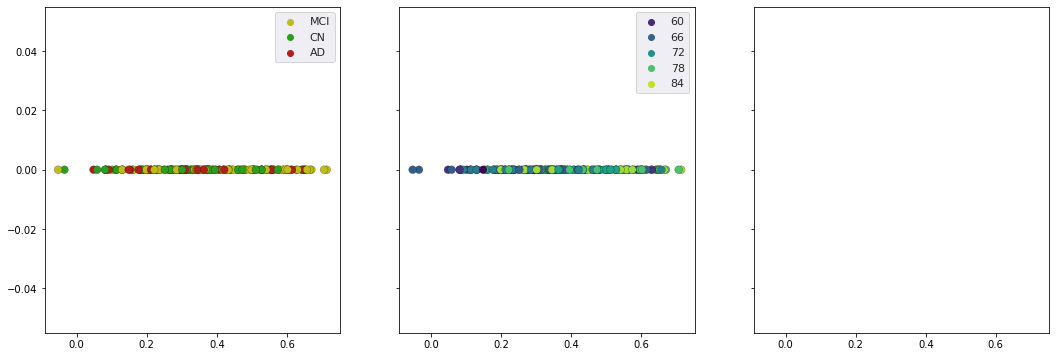

In [3]:
#Start figures
qzx_test = [np.array(x) for x in X_test_fwd['qzx']]
z_test = np.array([np.array(z).swapaxes(0,1) for z in X_test_fwd['z']])
print(z_test.shape)
#z_test_base = z_test[0]
# WE CANNOT DO A DIRECT MEAN: WE SHOULD ONLY D, FOR EACH TIMEPOINT, THE ONES THAT HAVE A MASK=TRUE
mask_test_norepeat = [x.cpu() for x in mask_test_norepeat]

#### Triple figure: One colored by tp, one colored by dx, and one colored by age
#plot_z_time_2d(z, max_timepoints, [dim0, dim1], out_dir, out_name='latent_space_2d')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18,6), sharex=True, sharey=True)
sns.set()
sns.set_theme()
# create color cmap for TP and AGE
colors = sns.color_palette("viridis", as_cmap=True)

#Pallete for DX
colors_dx = sns.color_palette(["#bfbc1a", "#2a9e1e", "#af1f1f"])

# pallete for age
age_full = [x for elem in Y_test["AGE_demog"] for x in elem]
bins, retstep = np.linspace(min(age_full), max(age_full), 8, retstep=True)
age_digitized = [np.digitize(y, bins) for y in Y_test["AGE_demog"]]

z_d0_full = []
z_d1_full = []
tp_full = []
color_dx = []
color_age = []

# Create dictionary of the different labels
# dx_dict = {
#     "NL": "CN",
#     "MCI": "MCI",
#     "MCI to NL": "CN",
#     "Dementia": "AD",
#     "Dementia to MCI": "MCI",
#     "NL to MCI": "MCI",
#     "MCI to Dementia": "AD",
# }

#### DIMENSIONS TO PLOT:
dim0 = 0
dim1 = 28

for tp in range(ntp):
    mask_i = [mask_ch[tp, :, :] for i, mask_ch in enumerate(mask_test_norepeat) if mask_ch.shape[0] > tp]
    mask_for_z = [mask_ti[:,0].repeat((z_test.shape[3], 1)).T.numpy() for mask_ti in mask_i]
    z_tp = [z_ch[:, tp, :] for z_ch in z_test if z_ch.shape[1] > tp]
    #compute the mean for each subject of z which are known
    z_tp_masked = []
    for i in range(len(mask_for_z)):
        z_tp[i][~mask_for_z[i]] = 0
        z_tp_masked.append(z_tp[i])
    z_num = np.sum(np.array(z_tp_masked), axis=0)
    z_dec = np.sum(np.array(mask_for_z), axis=0)
    z_test_tp = z_num / z_dec
    #test_z_d0 = [x[tp, dim0] for (i, x) in enumerate(z_test_tp) if x.shape[0] > tp and mask_test_list[2][tp,i,0]]
    #test_z_d1 = [x[tp, dim1] for (i, x) in enumerate(z_test_tp) if x.shape[0] > tp and mask_test_list[2][tp,i,0]]
    test_z_d0 = [x[dim0] for (i, x) in enumerate(z_test_tp) if z_dec[i,dim0] > 0]
    test_z_d1 = [x[dim1] for (i, x) in enumerate(z_test_tp) if z_dec[i,dim0] > 0]
    
    z_d0_full = z_d0_full + test_z_d0
    z_d1_full = z_d1_full + test_z_d1
    
    tp_len = len(test_z_d0)
    tp_full = tp_full + [tp]*tp_len

    # Prepare AGE for plotting
    color_test_dx = [x[tp] for i, x in enumerate(Y_test["DX"]) if x.shape[0] > tp and z_dec[i,dim0] > 0]
    color_test_age = [bins[x[tp]-1] for i, x in enumerate(age_digitized) if x.shape[0] > tp and z_dec[i,dim0] > 0]
    color_dx = color_dx + color_test_dx
    color_age = color_age + color_test_age
    break # IF NOT COMMENTED, USE ONLY BASELINE

print(len(color_age))
print(len(color_dx))
# ax1: dx
sns.scatterplot(x=z_d0_full, y=z_d1_full, hue=color_dx, palette=colors_dx, s=60, edgecolor="black", linewidth=0.2, ax=ax1)
# ax2: age
sns.scatterplot(x=z_d0_full, y=z_d1_full, hue=color_age, palette=colors, s=60, edgecolor="black", linewidth=0.2, ax=ax2)
# ax3: tp
sns.scatterplot(x=z_d0_full, y=z_d1_full, hue=tp_full, palette=colors, s=60, edgecolor="black", linewidth=0.2, ax=ax3)

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])


##Add title, x and y axis
#plt.xlabel(f"Dim {dim0}", size=13)
#plt.ylabel(f"Dim {dim1}", size=13)
# ax2.set_title(f"Latent space, dims 0 and 1", fontsize=20)
plt.tight_layout()
plt.savefig("fig_gen/latent_space_fig.png", dpi=300)
plt.show()